In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from IPython.core.interactiveshell import InteractiveShell
import warnings

In [2]:
sales_data = pd.read_csv("../../Data/sales_data.csv")
sales_data

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office,deal_won
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001.0,718.62,2448.0,United States,Unknown,GTX,1096.0,Dustin Brinkmann,Central,1
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002.0,3178.24,4540.0,United States,Unknown,Unknown,1096.0,Melvin Marxen,Central,1
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001.0,718.62,2448.0,United States,Unknown,MG,55.0,Melvin Marxen,Central,1
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998.0,2714.90,2641.0,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central,1
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982.0,792.46,1299.0,United States,Unknown,GTX,550.0,Summer Sewald,West,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,9MIWFW5J,Versie Hillebrand,MG Advanced,unknow,Prospecting,2017-06-24,2017-08-02,472.0,Unknown,Unknown,1698.20,3492.0,Unknown,Unknown,MG,3393.0,Dustin Brinkmann,Central,0
8796,6SLKZ8FI,Versie Hillebrand,MG Advanced,unknow,Prospecting,2017-06-24,2017-08-02,472.0,Unknown,Unknown,1698.20,3492.0,Unknown,Unknown,MG,3393.0,Dustin Brinkmann,Central,0
8797,LIB4KUZJ,Versie Hillebrand,MG Advanced,unknow,Prospecting,2017-06-24,2017-08-02,472.0,Unknown,Unknown,1698.20,3492.0,Unknown,Unknown,MG,3393.0,Dustin Brinkmann,Central,0
8798,18IUIUK0,Versie Hillebrand,MG Advanced,unknow,Prospecting,2017-06-24,2017-08-02,472.0,Unknown,Unknown,1698.20,3492.0,Unknown,Unknown,MG,3393.0,Dustin Brinkmann,Central,0


In [3]:
sales_data['engage_date'] = pd.to_datetime(sales_data['engage_date'])
sales_data['close_date'] = pd.to_datetime(sales_data['close_date'], errors='coerce')
sales_data['deal_duration'] = (sales_data['close_date'] - sales_data['engage_date']).dt.days

In [4]:
# Remove invalid date rows
sales_data = sales_data.dropna(subset=['close_date'])

# Sort and Set Index
sales_data = sales_data.sort_values('close_date')
sales_data.set_index('close_date', inplace=True)

In [5]:
# Feature Engineering (Interaction & Polynomial Features)
sales_data['employees_x_revenue'] = sales_data['employees'] * sales_data['revenue']
sales_data['employees_x_deal_duration'] = sales_data['employees'] * sales_data['deal_duration']
sales_data['revenue_x_deal_duration'] = sales_data['revenue'] * sales_data['deal_duration']

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(sales_data[['employees', 'revenue', 'deal_duration']])
poly_columns = poly.get_feature_names_out(['employees', 'revenue', 'deal_duration'])
poly_df = pd.DataFrame(poly_features, columns=poly_columns, index=sales_data.index)
sales_data = pd.concat([sales_data, poly_df], axis=1)

In [6]:
# Feature Selection
features = ['sector', 'employees', 'revenue', 'sales_price', 'deal_duration',
            'employees_x_revenue', 'employees_x_deal_duration', 'revenue_x_deal_duration'] + list(poly_columns)
X = sales_data[features]
y = sales_data['deal_won']

In [7]:
# Convert Categorical Features
X = pd.get_dummies(X, columns=['sector'], drop_first=True)

# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [8]:
# Train/Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
models = {
    "XGBoost": xgb.XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=8, colsample_bytree=0.7, subsample=0.8, gamma=0.2, reg_lambda=1, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=8, colsample_bytree=0.7, subsample=0.8, verbose=-1, random_state=42),
    "CatBoost": cb.CatBoostClassifier(iterations=300, learning_rate=0.03, depth=8, verbose=0, random_state=42)
}

In [10]:
InteractiveShell.ast_node_interactivity = "all"

results = []

# Suppress warnings globally
warnings.filterwarnings("ignore")

# Iterate through models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=["Not Won", "Won"], output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store results in a DataFrame for better readability
    results.append([name, accuracy, conf_matrix, class_report])
    
# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Confusion Matrix", "Classification Report"])

# Display results
for index, row in results_df.iterrows():
    print(f"\n{row['Model']} Model Performance:")
    print("Accuracy:", row["Accuracy"])
    print("Confusion Matrix:\n", row["Confusion Matrix"])
    print("Classification Report:\n", pd.DataFrame(row["Classification Report"]).transpose())


XGBoost Model Performance:
Accuracy: 0.6882191780821918
Confusion Matrix:
 [[511 423]
 [146 745]]
Classification Report:
               precision    recall  f1-score      support
Not Won        0.777778  0.547109  0.642363   934.000000
Won            0.637842  0.836139  0.723652   891.000000
accuracy       0.688219  0.688219  0.688219     0.688219
macro avg      0.707810  0.691624  0.683008  1825.000000
weighted avg   0.709459  0.688219  0.682050  1825.000000

LightGBM Model Performance:
Accuracy: 0.7013698630136986
Confusion Matrix:
 [[490 444]
 [101 790]]
Classification Report:
               precision    recall  f1-score     support
Not Won        0.829103  0.524625  0.642623   934.00000
Won            0.640194  0.886644  0.743529   891.00000
accuracy       0.701370  0.701370  0.701370     0.70137
macro avg      0.734649  0.705635  0.693076  1825.00000
weighted avg   0.736874  0.701370  0.691887  1825.00000

CatBoost Model Performance:
Accuracy: 0.6991780821917808
Confusion Matrix:

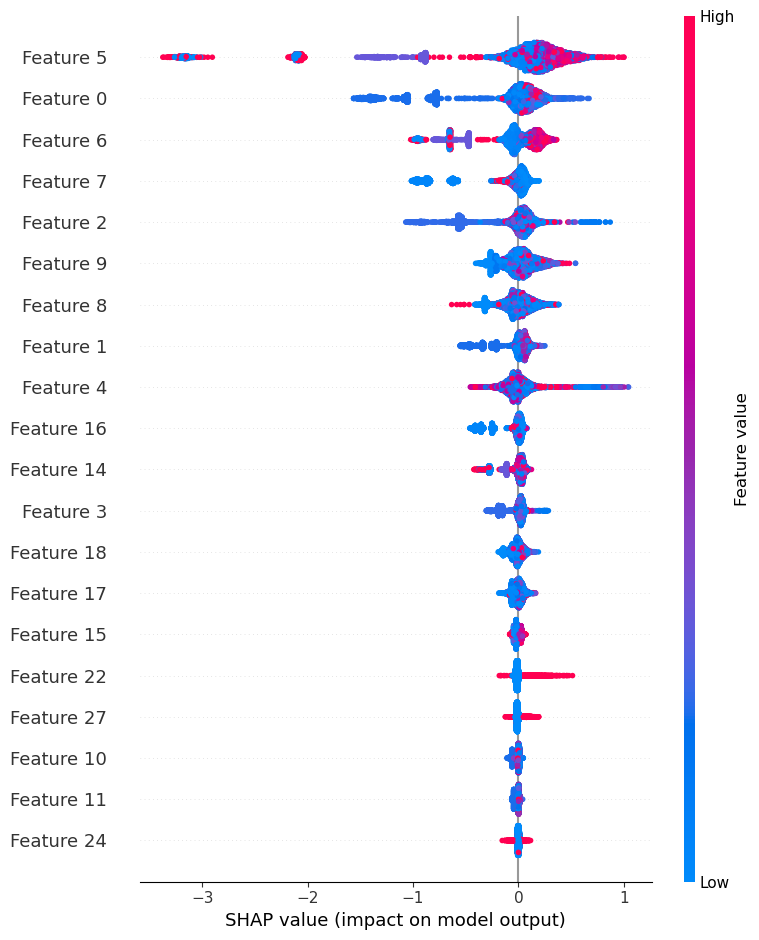

In [11]:
#  Feature Importance with SHAP
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

<Axes: title={'center': 'Feature Importance in Lead Conversion'}>

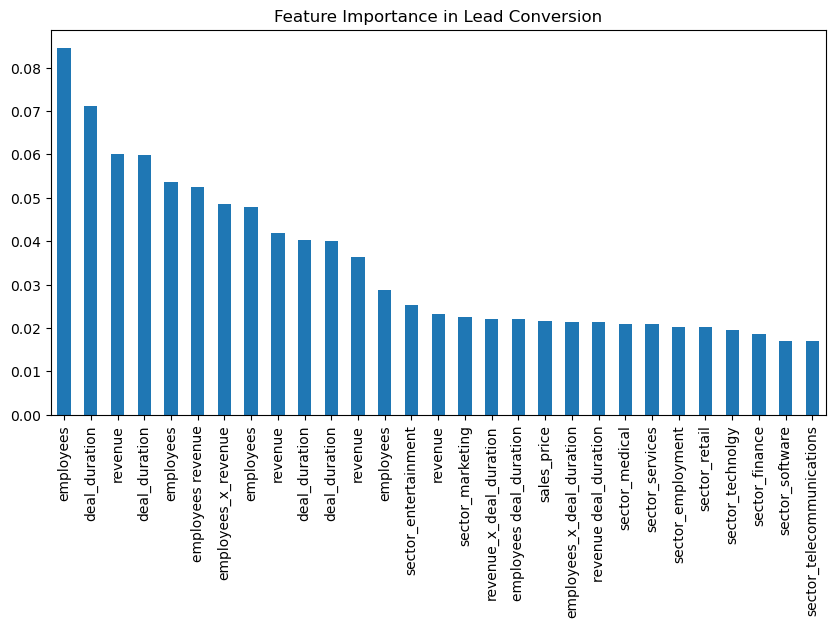

In [12]:
# Feature Importance Plot
feature_importance = pd.Series(models["XGBoost"].feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Feature Importance in Lead Conversion', figsize=(10, 5))
plt.show()

In [13]:
#  Aggregate Sales Data for Time Series
df_sales = sales_data.groupby('close_date')['close_value'].sum().reset_index()

df_sales['close_date'] = pd.to_datetime(df_sales['close_date'], errors='coerce')
df_sales = df_sales.dropna(subset=['close_date'])
df_sales = df_sales.sort_values('close_date')
df_sales.set_index('close_date', inplace=True)

In [14]:
# Remove Outliers using IQR
Q1 = df_sales['close_value'].quantile(0.25)
Q3 = df_sales['close_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_sales_clean = df_sales[(df_sales['close_value'] >= lower_bound) & (df_sales['close_value'] <= upper_bound)]

In [15]:
#   Resample Monthly for Forecasting
df_sales_clean = df_sales_clean.resample('M').sum()
df_sales_clean['close_value'] = np.log1p(df_sales_clean['close_value'])

In [16]:
# Exponential Smoothing Forecast
model_es = ExponentialSmoothing(df_sales_clean['close_value'], trend='add', seasonal='add', seasonal_periods=3)
fitted_model_es = model_es.fit()
forecast_es = fitted_model_es.forecast(steps=6)

In [17]:
# ARIMA Forecast
auto_arima_model = auto_arima(df_sales_clean['close_value'], seasonal=False)
order = auto_arima_model.order
model_arima = ARIMA(df_sales_clean['close_value'], order=order)
fitted_model_arima = model_arima.fit()
forecast_arima = fitted_model_arima.forecast(steps=6)

In [18]:
# Inverse Log Transform
forecast_es = np.expm1(forecast_es)  
forecast_arima = np.expm1(forecast_arima)

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Sales Forecast (Next 6 Months)')

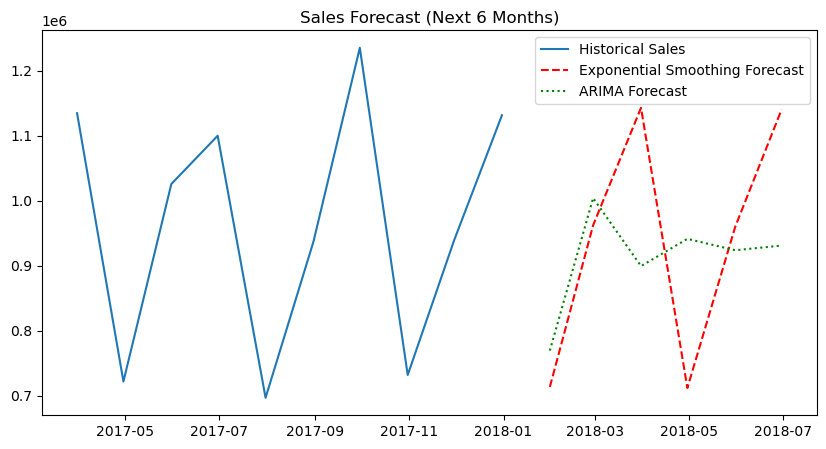

In [19]:
# Plot Forecast Results
plt.figure(figsize=(10, 5))
plt.plot(df_sales_clean.index, np.expm1(df_sales_clean['close_value']), label="Historical Sales")
plt.plot(forecast_es.index, forecast_es, label="Exponential Smoothing Forecast", linestyle='dashed', color='red')
plt.plot(forecast_arima.index, forecast_arima, label="ARIMA Forecast", linestyle='dotted', color='green')
plt.legend()
plt.title("Sales Forecast (Next 6 Months)")
plt.show()